# Input Data Generator 

The main aim of the module is generate synthetic data for production planning problem. 

## Configure the environment 

In [1]:
# You may need to uncomment the following command to install the necessary third-party packages the first time you run this notebook.
# !pip install pandas numpy seaborn

### Import required libraries

In [1]:
import os

import pandas as pd
import numpy as np
from random import uniform
import seaborn as sns

## Set Parameters

In [2]:
# Number of production sites
no_production_site = 100

# Average number of raw materials per product
average_raw_material_per_product = 10

# Cost of raw material per unit
raw_material_cost = 10

# Machine details
machines = {
    "Machine1": {
        "cost": 20,
        "available_time": 120,  # Available time in minutes
        "average_production_time_per_product": 24,  # Average production time per product in minutes
        "WeeklyAvailableTimeInHour": None  # Weekly available time in hours, to be calculated later
    },
    "Machine2": {
        "cost": 30,
        "available_time": 100,
        "average_production_time_per_product": 20,
        "WeeklyAvailableTimeInHour": None
    },
    "Machine3": {
        "cost": 40,
        "available_time": 80,
        "average_production_time_per_product": 16,
        "WeeklyAvailableTimeInHour": None
    }
}

# Maximum and minimum market demand per production
maximum_market_demand_per_production = 20
minimum_market_demand_per_production = 2

# Profit margin per product
profit_margin = 100

# Product groups with their offsets
product_groups = {
    "A": {
        "offsets": [1, 1]
    }, 
    "B": {
        "offsets": [1.5, 2]
    }, 
    "C": {
        "offsets": [2, 3]
    }
}

# Number of products per group
number_of_products_per_group = 10

# Profit margin for product group
profit_margin_for_product_group = 100

## Generate Production Planning Data

### Machine Data 

In [3]:
# Define columns for machine data
columns = ['ProductionSiteID', 'MachineID', 'MachineWeeklyAvailableTimeInHour', 'MachineCostPerHour']

# Create an empty dictionary to store machine data
machine_data = {col: list() for col in columns}

# Iterate through each production site and machine to generate machine data
for production_site_no in range(1, no_production_site+1):
    for machine_id in machines.keys():
        # Append production site ID, machine ID, weekly available time, and cost per hour to the respective lists
        machine_data['ProductionSiteID'].append(f"S{production_site_no:03}")  # Format production site ID
        machine_data['MachineID'].append(machine_id)
        # Calculate weekly available time and cost per hour with a random variation
        machine_data['MachineWeeklyAvailableTimeInHour'].append(round((machines[machine_id]["available_time"] + 5 * uniform(0, 1)), 0))
        machine_data['MachineCostPerHour'].append(round((machines[machine_id]["cost"] + 5 * uniform(0, 1)), 0))
        
# Convert machine data dictionary to a DataFrame
machine_data_df = pd.DataFrame(machine_data)

# Display the first few rows of the DataFrame
machine_data_df.head()

,ProductionSiteID,MachineID,MachineWeeklyAvailableTimeInHour,MachineCostPerHour
0,S001,Machine1,121.0,25.0
1,S001,Machine2,104.0,32.0
2,S001,Machine3,82.0,45.0
3,S002,Machine1,122.0,24.0
4,S002,Machine2,100.0,31.0


### Product Data

In [4]:
# Define columns for product data
columns = ['ProductionSiteID', 'ProductID', 'ProductGroup', 'RawMaterialPerProduct', 'RawMaterialCost',
           'MinimumMarketDemandPerProduct', 'MaximumMarketDemandPerProduct', 'ProductPrice']

# Create an empty dictionary to store product data
product_data = {col: list() for col in columns}

# Define columns for product machine data
columns = ['ProductionSiteID', 'ProductID', 'MachineID', 'ProductMachineLaborTimeInMin']

# Create an empty dictionary to store product machine data
product_machine_data = {col: list() for col in columns}

# Iterate through each production site, product group, and product to generate product data
for production_site_no in range(1, no_production_site+1):
    for product_group in product_groups.keys():
        for product_no in range(1, number_of_products_per_group+1):
            # Format production site ID and product ID
            production_site_id = f"S{production_site_no:03}"
            product_id = f"P_{production_site_id}_{product_group}_{product_no:02}"
            
            # Append production site ID, product ID, product group, raw material per product, raw material cost,
            # minimum and maximum market demand per product, and product price to the respective lists
            product_data['ProductionSiteID'].append(production_site_id)
            product_data['ProductID'].append(product_id)
            product_data['ProductGroup'].append(product_group)
            offset = product_groups[product_group]["offsets"][0]
            product_data['RawMaterialPerProduct'].append(round(offset * (average_raw_material_per_product + 5 * uniform(0, 1)), 0))
            product_data['RawMaterialCost'].append(raw_material_cost)
            product_data['MinimumMarketDemandPerProduct'].append(int(round(minimum_market_demand_per_production * uniform(0, 1), 0)))
            product_data['MaximumMarketDemandPerProduct'].append(int(maximum_market_demand_per_production))
            
            # Initialize production cost
            production_cost = 0.0
            
            # Iterate through each machine to generate product machine data
            for machine_id in machines.keys():
                # Append production site ID, product ID, machine ID, and product machine labor time in minutes to the respective lists
                product_machine_data['ProductionSiteID'].append(production_site_id)
                product_machine_data['ProductID'].append(product_id)
                product_machine_data['MachineID'].append(machine_id)
                product_machine_data['ProductMachineLaborTimeInMin'].append(round(offset * (machines[machine_id]["average_production_time_per_product"] - 5 + 5 * uniform(0, 1)), 0))
                
                # Calculate production cost for each machine
                production_cost += (product_machine_data['ProductMachineLaborTimeInMin'][-1] / 60.0) * machine_data_df['MachineCostPerHour'][(machine_data_df['ProductionSiteID'] == production_site_id) &
                                                                                                                                             (machine_data_df['MachineID'] == machine_id)].values[0]
            
            # Calculate product raw material cost and product price
            product_raw_material_cost = product_data['RawMaterialPerProduct'][-1] * product_data['RawMaterialCost'][-1]
            offset = product_groups[product_group]["offsets"][1]
            product_data['ProductPrice'].append(round(offset * profit_margin + 1.1 * (production_cost + product_raw_material_cost), 0))

# Convert product data dictionary to a DataFrame
product_data_df = pd.DataFrame(product_data)

# Display the first few rows of the product data DataFrame
display(product_data_df.head())

# Convert product machine data dictionary to a DataFrame
product_machine_data_df = pd.DataFrame(product_machine_data)

# Display the first few rows of the product machine data DataFrame
display(product_machine_data_df.head())

,ProductionSiteID,ProductID,ProductGroup,RawMaterialPerProduct,RawMaterialCost,MinimumMarketDemandPerProduct,MaximumMarketDemandPerProduct,ProductPrice
0,S001,P_S001_A_01,A,13.0,10,1,20,274.0
1,S001,P_S001_A_02,A,11.0,10,0,20,255.0
2,S001,P_S001_A_03,A,14.0,10,1,20,282.0
3,S001,P_S001_A_04,A,12.0,10,1,20,265.0
4,S001,P_S001_A_05,A,13.0,10,0,20,276.0


,ProductionSiteID,ProductID,MachineID,ProductMachineLaborTimeInMin
0,S001,P_S001_A_01,Machine1,20.0
1,S001,P_S001_A_01,Machine2,16.0
2,S001,P_S001_A_01,Machine3,15.0
3,S001,P_S001_A_02,Machine1,24.0
4,S001,P_S001_A_02,Machine2,18.0


### Inventory Data

In [5]:
# Define columns for inventory data
columns = ['ProductionSiteID', 'RawMaterialInventory']

# Create an empty dictionary to store inventory data
inventory_data = {col: list() for col in columns}

# Iterate through each production site to generate inventory data
for production_site_no in range(1, no_production_site+1):
    # Format production site ID
    production_site_id = f"S{production_site_no:03}"
    
    # Extract relevant data from the product data DataFrame for the current production site
    temp_df = product_data_df[['RawMaterialPerProduct', 'MaximumMarketDemandPerProduct']][product_data_df['ProductionSiteID'] == production_site_id]
    
    # Calculate raw material inventory for the current production site
    raw_material_inventory = (temp_df['RawMaterialPerProduct'] * temp_df['MaximumMarketDemandPerProduct']).sum()
    raw_material_inventory += 0.1 * uniform(0, 1) * raw_material_inventory  # Add a random variation to the inventory
    
    # Append production site ID and raw material inventory to the respective lists
    inventory_data['ProductionSiteID'].append(production_site_id)
    inventory_data['RawMaterialInventory'].append(raw_material_inventory)

# Convert inventory data dictionary to a DataFrame
inventory_data_df = pd.DataFrame(inventory_data)

# Display the first few rows of the inventory data DataFrame
display(inventory_data_df.head())

,ProductionSiteID,RawMaterialInventory
0,S001,11825.641052
1,S002,11128.419218
2,S003,12296.680554
3,S004,11785.774006
4,S005,11438.821988


## Analysis 

In [6]:
# Utility function
def get_histogram_grid(data: pd.DataFrame, x: str, x_label: str, title: str, col: str, bins=10):
    """
    Creates a grid (or row) of histograms from the given DataFrame, with each histogram representing a subset of the data
    based on the unique values of the specified column.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data to plot.
    x (str): The name of the column to be plotted on the x-axis of the histograms.
    x_label (str): The label for the x-axis.
    title (str): The overall title for the entire grid of histograms.
    col (str): The name of the column used to split the data into different subsets for each histogram.
    bins (int, optional): The number of bins to use in the histograms. Default is 10.
    
    Returns:
    None
    """
    # Create a FacetGrid, splitting the data into columns based on the unique values of the 'col' parameter
    g = sns.FacetGrid(data, col=col)

    # Map the sns.histplot function to the grid, plotting the 'x' column with the specified number of bins
    g.map_dataframe(sns.histplot, x=x, bins=bins)

    # Set the x-axis label for all histograms in the grid
    g.set_axis_labels(x_label, "Count")

    # Set the overall title for the grid of histograms
    g.fig.suptitle(title)

    # Adjust the top margin to make room for the overall title
    g.fig.subplots_adjust(top=0.85)

### Product Data

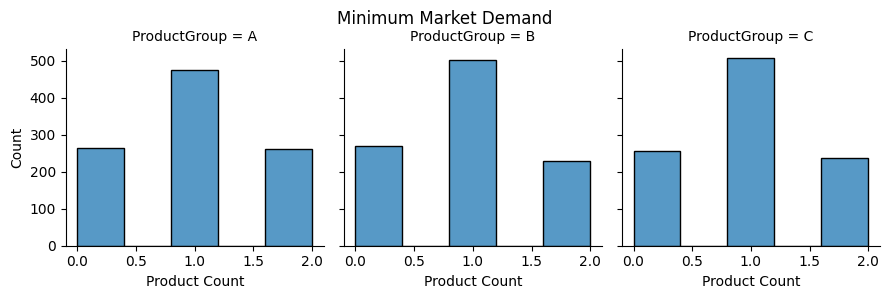

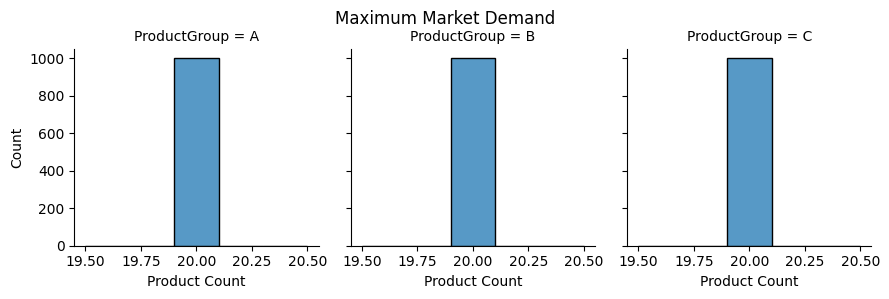

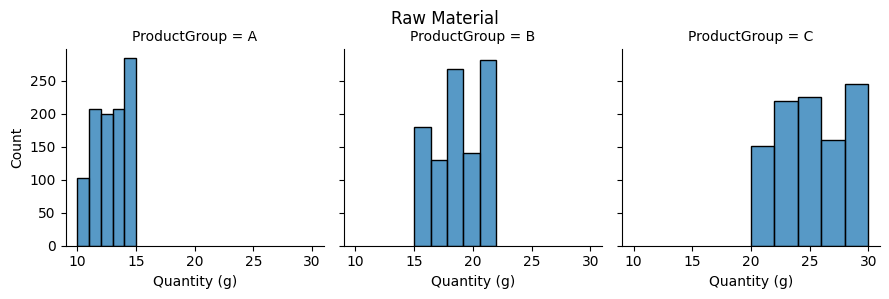

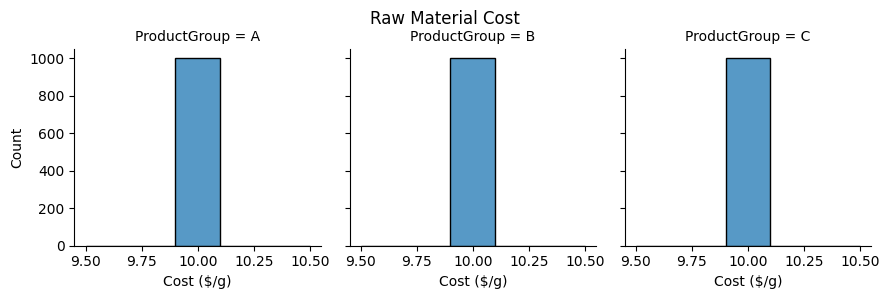

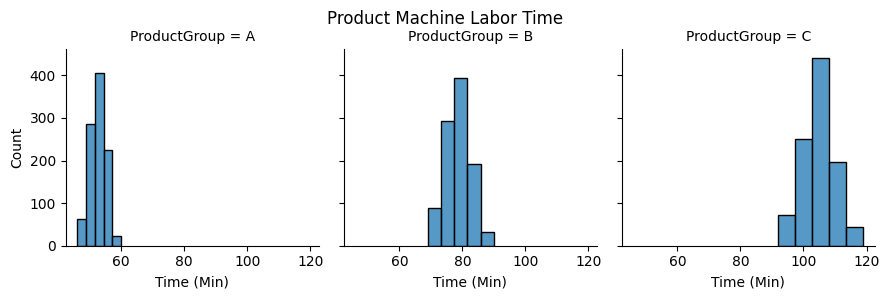

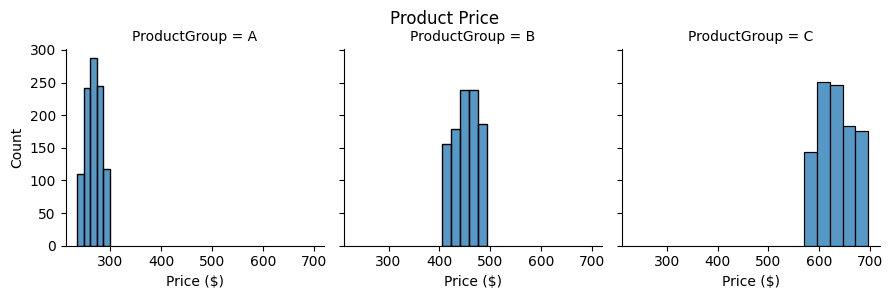

In [7]:
columns = ['ProductGroup', 'MinimumMarketDemandPerProduct', 'MaximumMarketDemandPerProduct',
           'RawMaterialPerProduct', 'RawMaterialCost', 'ProductMachineLaborTimeInMin',
           'ProductPrice' ]
titles = [' ', 'Minimum Market Demand', 'Maximum Market Demand',
           'Raw Material', 'Raw Material Cost', 'Product Machine Labor Time',
           'Product Price' ]
x_labels = [' ', 'Product Count', 'Product Count',
           'Quantity (g)', 'Cost ($/g)', 'Time (Min)',
           'Price ($)' ]
product_machine_time_df = product_machine_data_df[['ProductionSiteID', 'ProductID', 'ProductMachineLaborTimeInMin']].groupby(by=['ProductionSiteID', 'ProductID'], as_index=False).sum()
temp_df = product_data_df.merge(product_machine_time_df, on=['ProductionSiteID', 'ProductID'], how='inner')
for i in range(1,len(columns)):
    get_histogram_grid(data=temp_df, col='ProductGroup', x=columns[i], x_label=x_labels[i], title=titles[i], bins=5)

### Machine Data 

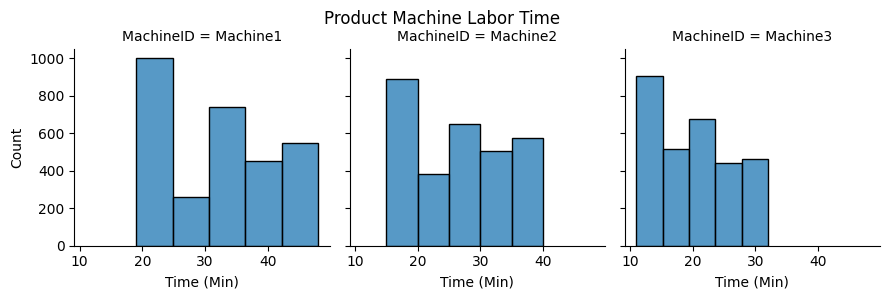

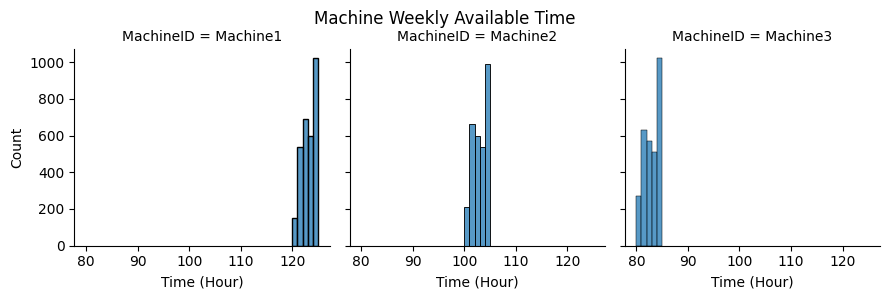

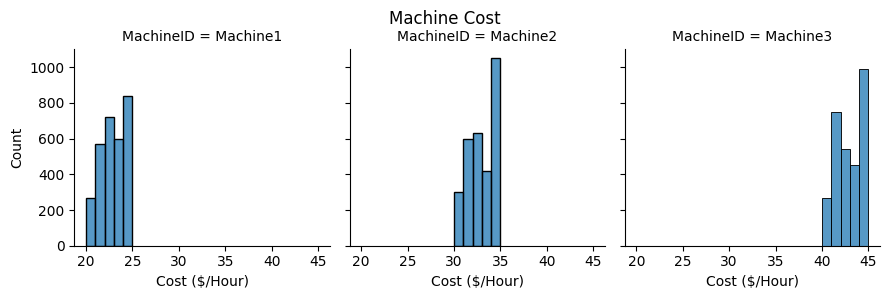

In [8]:
columns = ['MachineID', 'ProductMachineLaborTimeInMin',	'MachineWeeklyAvailableTimeInHour', 'MachineCostPerHour' ]
titles = ['', 'Product Machine Labor Time ',	'Machine Weekly Available Time', 'Machine Cost' ]
x_labels = ['', 'Time (Min)',	'Time (Hour)', 'Cost ($/Hour)' ]

temp_df = machine_data_df.merge(product_machine_data_df, on=['ProductionSiteID', 'MachineID'], how='inner')
for i in range(1, len(columns)):
    get_histogram_grid(data=temp_df, col='MachineID', x=columns[i], title=titles[i], x_label=x_labels[i], bins=5)

### Inventory Data

Text(0.5, 1.0, 'Production Sites Raw Materials Inventory')

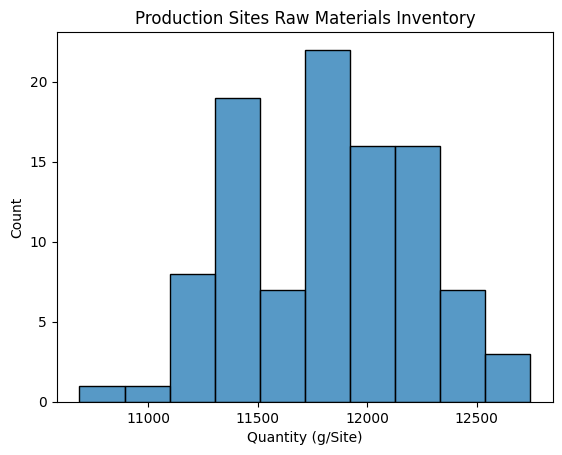

In [9]:
ax = sns.histplot(inventory_data_df, x='RawMaterialInventory', bins=10)
ax.set_xlabel('Quantity (g/Site)')
ax.set_title('Production Sites Raw Materials Inventory')

## Write Data

In [10]:
# File I/O
out_file_path = "./resources/data/input/"

out_file_name = f"machine_data_{no_production_site:02}_site.csv"
out_file = os.path.join(out_file_path, out_file_name)
machine_data_df.to_csv(os.path.join(out_file_path, out_file_name), index=False)
print(f"Machine Data file saved: {out_file}")

product_data_df.drop(columns=['ProductGroup'], axis=1, inplace=True)
out_file_name = f"product_data_{no_production_site:02}_site.csv"
out_file = os.path.join(out_file_path, out_file_name)
product_data_df.to_csv(os.path.join(out_file_path, out_file_name), index=False)
print(f"Product Data file saved: {out_file}")

out_file_name = f"product_machine_data_{no_production_site:02}_site.csv"
out_file = os.path.join(out_file_path, out_file_name)
product_machine_data_df.to_csv(os.path.join(out_file_path, out_file_name), index=False)
print(f"Product Machine Data file saved: {out_file}")

out_file_name = f"inventory_data_data_{no_production_site:02}_site.csv"
out_file = os.path.join(out_file_path, out_file_name)
inventory_data_df.to_csv(os.path.join(out_file_path, out_file_name), index=False)
print(f"Inventory Data file saved: {out_file}")

Machine Data file saved: ./resources/data/input/machine_data_100_site.csv
Product Data file saved: ./resources/data/input/product_data_100_site.csv
Product Machine Data file saved: ./resources/data/input/product_machine_data_100_site.csv
Inventory Data file saved: ./resources/data/input/inventory_data_data_100_site.csv


# END